## Evaluation Metrics and Scoring

So far, we have evaluated classification performance using accuracy (the fraction of correctly classified samples) and regression performance using R2. However, these are only two of the many possible ways to summarize how well a supervised model performs on a given dataset. In practice, these evaluation metrics might not be appropriate for your application, and it is important to choose the right metric when selecting between models and adjusting parameters.

### Keep the End Goal in Mind

When selecting a metric, you should always have the end goal of the machine learning application in mind. In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decision-making process. Before picking a machine learning metric, you should think about the high-level goal of the application, often called the *business metric*. The consequences of choosing a particular algorithm for a machine learning application are called the *business impact*. 

Maybe the high-level goal is avoiding traffic accidents, or decreasing the number of hospital admissions. It could also be getting more users for your website, or having users spend more money in your shop. When choosing a model or adjusting parameters, you should pick the model or parameter values that have the most positive influence on the business metric. Often this is hard, as assessing the business impact of a particular model might require putting it in production in a real-life system.

In the early stages of development, and for adjusting parameters, it is often infeasible to put models into production just for testing purposes, because of the high business or personal risks that can be involved. Imagine evaluating the pedestrian avoidance capabilities of a self-driving car by just letting it drive around, without verifying it first; if your model is bad, pedestrians will be in trouble! 

Therefore we often need to find some surrogate evaluation procedure, using an evaluation metric that is easier to compute. For example, we could test classifying images of pedestrians against non-pedestrians and measure accuracy. Keep in mind that this is only a surrogate, and it pays off to find the closest metric to the original business goal that is feasible to evaluate. This closest metric should be used whenever possible for model evaluation and selection. The result of this evaluation might not be a single number—the consequence of your algorithm could be that you have 10% more customers, but each customer will spend 15% less—but it should capture the expected business impact of choosing one model over another.

In this section, we will first discuss metrics for the important special case of binary classification, then turn to multiclass classification and finally regression.

### Metrics for Binary Classification

Binary classification is arguably the most common and conceptually simple application of machine learning in practice. However, there are still a number of caveats in evaluating even this simple task. Before we dive into alternative metrics, let’s have a look at the ways in which measuring accuracy might be misleading. Remember that for binary classification, we often speak of a *positive class* and a *negative class*, with the understanding that the positive class is the one we are looking for.

#### Kinds of Errors

Often, accuracy is not a good measure of predictive performance, as the number of mistakes we make does not contain all the information we are interested in. Imagine an application to screen for the early detection of cancer using an automated test. 

If the test is negative, the patient will be assumed healthy, while if the test is positive, the patient will undergo additional screening. Here, we would call a positive test (an indication of cancer) the positive class, and a negative test the negative class. We can’t assume that our model will always work perfectly, and it will make mistakes. For any application, we need to ask ourselves what the consequences of these mistakes might be in the real world.

One possible mistake is that a healthy patient will be classified as positive, leading to additional testing. This leads to some costs and an inconvenience for the patient (and possibly some mental distress). An incorrect positive prediction is called a *false positive*. 

The other possible mistake is that a sick patient will be classified as negative, and will not receive further tests and treatment. The undiagnosed cancer might lead to serious health issues, and could even be fatal. A mistake of this kind—an incorrect negative prediction—is called a *false negative*. 

In statistics, a false positive is also known as *type I error*, and a false negative as *type II error*. We will stick to “false negative” and “false positive,” as they are more explicit and easier to remember. In the cancer diagnosis example, it is clear that we want to avoid false negatives as much as possible, while false positives can be viewed as more of a minor nuisance.

While this is a particularly drastic example, the consequence of false positives and false negatives are rarely the same. In commercial applications, it might be possible to assign dollar values to both kinds of mistakes, which would allow measuring the error of a particular prediction in dollars, instead of accuracy. This might be much more meaningful for making business decisions on which model to use.

#### Imbalanced Datasets

Types of errors play an important role when one of two classes is much more frequent than the other one. This is very common in practice; a good example is click-through prediction, where each data point represents an “impression,” an item that was shown to a user. This item might be an ad, or a related story, or a related person to follow on a social media site. The goal is to predict whether, if shown a particular item, a user will click on it (indicating they are interested). 

Most things users are shown on the Internet (in particular, ads) will not result in a click. You might need to show a user 100 ads or articles before they find something interesting enough to click on. This results in a dataset where for each 99 “no click” data points, there is 1 “clicked” data point; in other words, 99% of the samples belong to the “no click” class. Datasets in which one class is much more frequent than the other are often called imbalanced datasets, or datasets with imbalanced classes. In reality, imbalanced data is the norm, and it is rare that the events of interest have equal or even similar frequency in the data.

Now let’s say you build a classifier that is 99% accurate on the click prediction task. What does that tell you? 99% accuracy sounds impressive, but this doesn’t take the class imbalance into account. You can achieve 99% accuracy without building a machine learning model, by always predicting “no click.” On the other hand, even with imbalanced data, a 99% accurate model could in fact be quite good. However, accuracy doesn’t allow us to distinguish the constant “no click” model from a potentially good model.

To illustrate, we’ll create a 9:1 imbalanced dataset from the digits dataset, by classifying the digit 9 against the nine other classes:

In [31]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

We can use the *DummyClassifier* to always predict the majority class (here “not nine”) to see how uninformative accuracy can be:

In [33]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


We obtained close to 90% accuracy without learning anything. This might seem striking, but think about it for a minute. Imagine someone telling you their model is 90% accurate. You might think they did a very good job. But depending on the problem, that might be possible by just predicting one class! Let’s compare this against using an actual classifier:

In [34]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


According to accuracy, the *DecisionTreeClassifier* is only slightly better than the constant predictor. This could indicate either that something is wrong with how we used *DecisionTreeClassifier*, or that accuracy is in fact not a good measure here.

For comparison purposes, let’s evaluate two more classifiers, *LogisticRegression* and the default *DummyClassifier*, which makes random predictions but produces classes with the same proportions as in the training set:

In [35]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.83
logreg score: 0.98


The dummy classifier that produces random output is clearly the worst of the lot (according to accuracy), while *LogisticRegression* produces very good results. However, even the random classifier yields over 80% accuracy. This makes it very hard to judge which of these results is actually helpful. 

The problem here is that accuracy is an inadequate measure for quantifying predictive performance in this imbalanced setting. For the rest of this chapter, we will explore alternative metrics that provide better guidance in selecting models. In particular, we would like to have metrics that tell us how much better a model is than making “most frequent” predictions or random predictions, as they are computed in *pred_most_frequent* and *pred_dummy*. If we use a metric to assess our models, it should definitely be able to weed out these nonsense predictions.

#### Confusion Matrices

One of the most comprehensive ways to represent the result of evaluating binary classification is using confusion matrices. Let’s inspect the predictions of *LogisticRegression* from the previous section using the *confusion_matrix* function. We already stored the predictions on the test set in *pred_logreg*:

In [36]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


The output of *confusion_matrix* is a two-by-two array, where the rows correspond to the true classes and the columns correspond to the predicted classes. Each entry counts how often a sample that belongs to the class corresponding to the row (here, “not nine” and “nine”) was classified as the class corresponding to the column. The following plot illustrates this meaning:

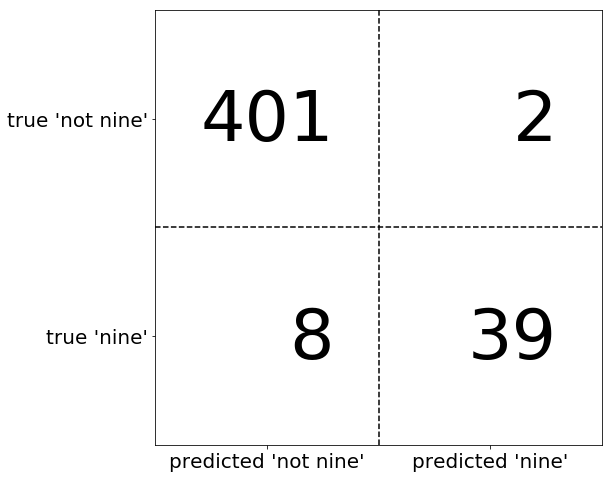

In [37]:
mglearn.plots.plot_confusion_matrix_illustration()

Entries on the main diagonal of the confusion matrix correspond to correct classifications, while other entries tell us how many samples of one class got mistakenly classified as another class.

If we declare “a nine” the positive class, we can relate the entries of the confusion matrix with the terms false positive and false negative that we introduced earlier. To complete the picture, we call correctly classified samples belonging to the positive class true positives and correctly classified samples belonging to the negative class true negatives. These terms are usually abbreviated FP, FN, TP, and TN and lead to the following interpretation for the confusion matrix:

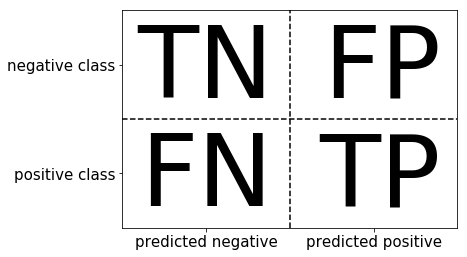

In [38]:
mglearn.plots.plot_binary_confusion_matrix()

Now let’s use the confusion matrix to compare the models we fitted earlier (the two dummy models, the decision tree, and the logistic regression):

In [39]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))

print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))

print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))

print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[360  43]
 [ 41   6]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


Looking at the confusion matrix, it is quite clear that something is wrong with *pred_most_frequent*, because it always predicts the same class. 

*pred_dummy*, on the other hand, has a very small number of true positives, particularly compared to the number of false negatives and false positives—there are many more false positives than true positives! 

The predictions made by the decision tree make much more sense than the dummy predictions, even though the accuracy was nearly the same. 

Finally, we can see that logistic regression does better than pred_tree in all aspects: it has more true positives and true negatives while having fewer false positives and false negatives. 

From this comparison, it is clear that only the decision tree and the logistic regression give reasonable results, and that the logistic regression works better than the tree on all accounts. However, inspecting the full confusion matrix is a bit cumbersome, and while we gained a lot of insight from looking at all aspects of the matrix, the process was very manual and qualitative. There are several ways to summarize the information in the confusion matrix, which we will discuss next.

##### Relation to Accuracy

We already saw one way to summarize the result in the confusion matrix—by computing accuracy, which can be expressed as:

Accuracy =  $\frac{TP + TN}{TP + TN + FP + FN}$

In other words, accuracy is the number of correct predictions (TP and TN) divided by the number of all samples (all entries of the confusion matrix summed up).

##### Precision, Recall, and f-score

There are several other ways to summarize the confusion matrix, with the most common ones being precision and recall. *Precision* measures how many of the samples predicted as positive are actually positive:

Precision = $\frac{TP}{TP + FP}$

Precision is used as a performance metric when the goal is to limit the number of false positives. As an example, imagine a model for predicting whether a new drug will be effective in treating a disease in clinical trials. Clinical trials are notoriously expensive, and a pharmaceutical company will only want to run an experiment if it is very sure that the drug will actually work. Therefore, it is important that the model does not produce many false positives—in other words, that it has a high precision. Precision is also known as *positive predictive value (PPV)*.

*Recall*, on the other hand, measures how many of the positive samples are captured by the positive predictions:

Recall = $\frac{TP}{TP + FN}$

Recall is used as performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives. The cancer diagnosis example from earlier in this chapter is a good example for this: it is important to find all people that are sick, possibly including healthy patients in the prediction. Other names for recall are *sensitivity*, *hit rate*, or *true positive rate (TPR)*.

There is a trade-off between optimizing recall and optimizing precision. You can trivially obtain a perfect recall if you predict all samples to belong to the positive class—there will be no false negatives, and no true negatives either. However, predicting all samples as positive will result in many false positives, and therefore the precision will be very low. On the other hand, if you find a model that predicts only the single data point it is most sure about as positive and the rest as negative, then precision will be perfect (assuming this data point is in fact positive), but recall will be very bad.

So, while precision and recall are very important measures, looking at only one of them will not provide you with the full picture. One way to summarize them is the *f-score* or *f-measure*, which is with the harmonic mean of precision and recall:

F = $2 * \frac{precision * recall}{precision + recall}$

This particular variant is also known as the *f1-score*. As it takes precision and recall into account, it can be a better measure than accuracy on imbalanced binary classification datasets. Let’s run it on the predictions for the “nine vs. rest” dataset that we computed earlier. Here, we will assume that the “nine” class is the positive class (it is labeled as True while the rest is labeled as False), so the positive class is the minority class:

In [40]:
from sklearn.metrics import f1_score

print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.12
f1 score tree: 0.55
f1 score logistic regression: 0.89


We can note two things here. First, we get an error message for the most_frequent prediction, as there were no predictions of the positive class (which makes the denominator in the *f-score* zero). Also, we can see a pretty strong distinction between the dummy predictions and the tree predictions, which wasn’t clear when looking at accuracy alone. Using the f-score for evaluation, we summarized the predictive performance again in one number. However, the f-score seems to capture our intuition of what makes a good model much better than accuracy did. A disadvantage of the f-score, however, is that it is harder to interpret and explain than accuracy.

If we want a more comprehensive summary of precision, recall, and f1-score, we can use the *classification_report* convenience function to compute all three at once, and print them in a nice format:

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, 
                            target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

   micro avg       0.90      0.90      0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



The *classification_report* function produces one line per class (here, True and False) and reports precision, recall, and f-score with this class as the positive class. Before, we assumed the minority “nine” class was the positive class. If we change the positive class to “not nine,” we can see from the output of classification_report that we obtain an *f-score* of 0.94 with the most_frequent model. Furthermore, for the “not nine” class we have a *recall* of 1, as we classified all samples as “not nine.” The last column next to the f-score provides the *support* of each class, which simply means the number of samples in this class according to the ground truth.

Three additional rows in the classification report show averages of the precision, recall, and f1-score. The *macro average* simply computes the average across the classes, while the *weighted average* computes a weighted average, weighted by the number of samples in the class. Because they are averages over both classes, these metrics don’t require a notion of positive class, and in contrast to just looking at precision or just looking at recall for the positive class, averaging over both classes provides a meaningful metric in a single number. Here are two more reports, one for the dummy classifier and one for the logistic regression:

In [42]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      0.89      0.90       403
        nine       0.12      0.13      0.12        47

   micro avg       0.81      0.81      0.81       450
   macro avg       0.51      0.51      0.51       450
weighted avg       0.82      0.81      0.82       450



In [43]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



As you may notice when looking at the reports, the differences between the dummy models and a very good model are not as clear any more. Picking which class is declared the positive class has a big impact on the metrics. While the *f-score* for the dummy classification is 0.10 (vs. 0.89 for the logistic regression) on the “nine” class, for the “not nine” class it is 0.91 vs. 0.99, which both seem like reasonable results. Looking at all the numbers together paints a pretty accurate picture, though, and we can clearly see the superiority of the logistic regression model.

#### Taking Uncertainty Into Account

The confusion matrix and the classification report provide a very detailed analysis of a particular set of predictions. However, the predictions themselves already threw away a lot of information that is contained in the model. As we discussed in Chapter 2, most classifiers provide a decision_function or a predict_proba method to assess degrees of certainty about predictions. Making predictions can be seen as thresholding the output of *decision_function* or *predict_proba* at a certain fixed point—in binary classification we use 0 for the decision function and 0.5 for predict_proba.

The following is an example of an imbalanced binary classification task, with 400 points in the negative class classified against 50 points in the positive class. The training data is shown on the left. We train a kernel SVM model on this data, and the plots to the right of the training data illustrate the values of the decision function as a heat map. You can see a black circle in the plot in the top center, which denotes the threshold of the *decision_function* being exactly zero. Points inside this circle will be classified as the positive class, and points outside as the negative class:

In [44]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

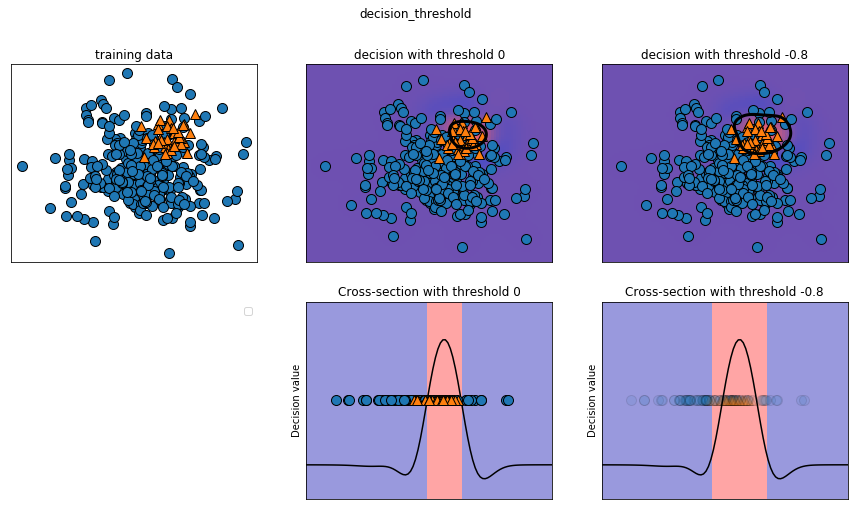

In [45]:
mglearn.plots.plot_decision_threshold()

We can use the *classification_report* function to evaluate precision and recall for both classes:

In [46]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



For class 1, we get a fairly small precision, and recall is mixed. Because class 0 is so much larger, the classifier focuses on getting class 0 right, and not the smaller class 1.

Let’s assume in our application it is more important to have a high recall for class 1, as in the cancer screening example earlier. This means we are willing to risk more false positives (false class 1) in exchange for more true positives (which will increase the recall). The predictions generated by *svc.predict* really do not fulfill this requirement, but we can adjust the predictions to focus on a higher recall of class 1 by changing the decision threshold away from 0. By default, points with a decision_function value greater than 0 will be classified as class 1. We want more points to be classified as class 1, so we need to decrease the threshold:

In [47]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

Let’s look at the classification report for this prediction:

In [48]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

   micro avg       0.83      0.83      0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



As expected, the recall of class 1 went up, and the precision went down. We are now classifying a larger region of space as class 1, as illustrated in the top-right panel of the above figure. If you value precision over recall or the other way around, or you data is heavily imbalanced, changing the decision threshold is the easiest way to obtain better results. 

As the decision_function can have arbitrary ranges, it is hard to provide a rule of thumb regarding how to pick a threshold. If you do set a threshold, you need to be careful not to do so using the test set. As with any other parameter, setting a decision threshold on the test set is likely to yield overly optimistic results. Use a validation set or cross-validation instead.

**Warning**

For simplicity, we changed the threshold value based on test set results in the code above. In practice, you need to use a hold-out validation set, not the test set. As with any other parameter, setting a decision threshold on the test set is likely to yield overly optimistic results. Use a validation set or cross-validation instead.

Picking a threshold for models that implement the *predict_proba* method can be easier, as the output of *predict_proba* is on a fixed 0 to 1 scale, and models probabilities. By default, the threshold of 0.5 means that if the model is more than 50% “sure” that a point is of the positive class, it will be classified as such. Increasing the threshold means that the model needs to be more confident to make a positive decision (and less confident to make a negative decision). 

While working with probabilities may be more intuitive than working with arbitrary thresholds, not all models provide realistic models of uncertainty (a *DecisionTree* that is grown to its full depth is always 100% sure of its decisions, even though it might often be wrong). This relates to the concept of calibration: a calibrated model is a model that provides an accurate measure of its uncertainty. 

Discussing calibration in detail is beyond the scope of this book, but you can find more details in the paper “Predicting Good Probabilities with Supervised Learning” by Alexandru Niculescu-Mizil and Rich Caruana.

#### Precision-Recall Curves and ROC Curves

As we just discussed, changing the threshold that is used to make a classification decision in a model is a way to adjust the trade-off of precision and recall for a given classifier. Maybe you want to miss less than 10% of positive samples, meaning a desired recall of 90%. 

This decision depends on the application, and it should be driven by business goals. Once a particular goal is set—say, a particular recall or precision value for a class—a threshold can be set appropriately. It is always possible to set a threshold to fulfill a particular target, like 90% recall. The hard part is to develop a model that still has reasonable precision with this threshold—if you classify everything as positive, you will have 100% recall, but your model will be useless.

Setting a requirement on a classifier like 90% recall is often called setting the *operating point*. Fixing an operating point is often helpful in business settings to make performance guarantees to customers or other groups inside your organization.

Often, when developing a new model, it is not entirely clear what the operating point will be. For this reason, and to understand a modeling problem better, it is instructive to look at all possible thresholds, or all possible trade-offs of precision and recall at once. 

This is possible using a tool called the *precision-recall curve*. You can find the function to compute the precision-recall curve in the *sklearn.metrics* module. It needs the ground truth labeling and predicted uncertainties, created via either *decision_function* or *predict_proba*:

In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

The *precision_recall_curve* function returns a list of precision and recall values for all possible thresholds (all values that appear in the decision function) in sorted order, so we can plot a curve, as seen here:

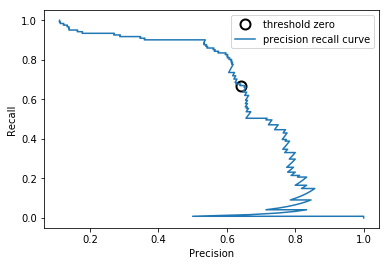

In [50]:
# Use more data points for a smoother curve
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

# Find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

Each point along the curve corresponds to a possible threshold of the *decision_function*. We can see, for example, that we can achieve a recall of 0.4 at a precision of about 0.75. The black circle marks the point that corresponds to a threshold of 0, the default threshold for *decision_function*. This point is the trade-off that is chosen when calling the predict method.

The closer a curve stays to the upper-right corner, the better the classifier. A point at the upper right means high precision and high recall for the same threshold. The curve starts at the top-left corner, corresponding to a very low threshold, classifying everything as the positive class. Raising the threshold moves the curve toward higher precision, but also lower recall. Raising the threshold more and more, we get to a situation where most of the points classified as being positive are true positives, leading to a very high precision but lower recall. The more the model keeps recall high as precision goes up, the better.

Looking at this particular curve a bit more, we can see that with this model it is possible to get a precision of up to around 0.5 with very high recall. If we want a much higher precision, we have to sacrifice a lot of recall. In other words, on the left the curve is relatively flat, meaning that recall does not go down a lot when we require increased precision. For precision greater than 0.5, each gain in precision costs us a lot of recall.

Different classifiers can work well in different parts of the curve—that is, at different operating points. Let’s compare the SVM we trained to a random forest trained on the same dataset. The *RandomForestClassifier* doesn’t have a *decision_function*, only *predict_proba*. 

The *precision_recall_curve* function expects as its second argument a certainty measure for the positive class (class 1), so we pass the probability of a sample being class 1—that is, *rf.predict_proba(X_test)[:, 1]*. The default threshold for *predict_proba* in binary classification is 0.5, so this is the point we marked on the curve:

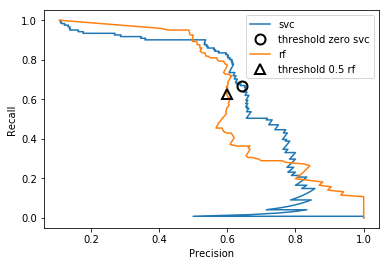

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

From the comparison plot we can see that the random forest performs better at the extremes, for very high recall or very high precision requirements. Around the middle (approximately precision=0.7), the SVM performs better. If we only looked at the f1-score to compare overall performance, we would have missed these subtleties. The f1-score only captures one point on the precision-recall curve, the one given by the default threshold:

In [52]:
print("f1_score of random forest: {:.3f}".format(
    f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


Comparing two precision-recall curves provides a lot of detailed insight, but is a fairly manual process. For automatic model comparison, we might want to summarize the information contained in the curve, without limiting ourselves to a particular threshold or operating point. 

One particular way to summarize the precision-recall curve is by computing the integral or area under the curve of the precision-recall curve, also known as the average precision.  You can use the *average_precision_score* function to compute the average precision. Because we need to compute the precision-recall curve and consider multiple thresholds, the result of *decision_function* or *predict_proba* needs to be passed to *average_precision_score*, not the result of predict:

In [53]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


When averaging over all possible thresholds, we see that the random forest and SVC perform similarly well, with the random forest even slightly ahead. This is quite different from the result we got from *f1_score* earlier. Because average precision is the area under a curve that goes from 0 to 1, average precision always returns a value between 0 (worst) and 1 (best). The average precision of a classifier that assigns *decision_function* at random is the fraction of positive samples in the dataset.

#### Receiver Operating Characteristics (ROC) and AUC

There is another tool that is commonly used to analyze the behavior of classifiers at different thresholds: the *receiver operating characteristics* curve, or *ROC curve* for short. Similar to the precision-recall curve, the ROC curve considers all possible thresholds for a given classifier, but instead of reporting precision and recall, it shows the *false positive rate (FPR)* against the *true positive rate (TPR)*. Recall that the true positive rate is simply another name for recall, while the false positive rate is the fraction of false positives out of all negative samples:

FPR = $\frac{FP}{FP + TN}$

The ROC curve can be computed using the *roc_curve* function:

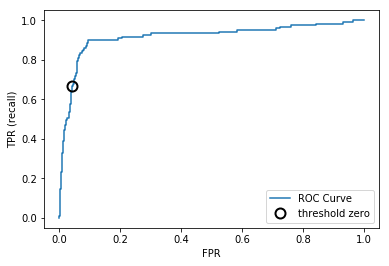

In [54]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# Find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

For the ROC curve, the ideal curve is close to the top left: you want a classifier that produces a *high recall* while keeping a *low false positive rate*&. Compared to the default threshold of 0, the curve shows that we can achieve a significantly higher recall (around 0.9) while only increasing the FPR slightly. The point closest to the top left might be a better operating point than the one chosen by default. Again, be aware that choosing a threshold should not be done on the test set, but on a separate validation set.

You can find a comparison of the random forest and the SVM using ROC curves here:

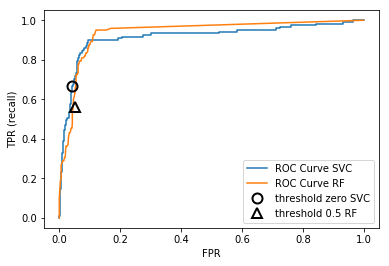

In [55]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

As for the precision-recall curve, we often want to summarize the ROC curve using a single number, the area under the curve (this is commonly just referred to as the AUC, and it is understood that the curve in question is the ROC curve). We can compute the area under the ROC curve using the *roc_auc_score* function:

In [56]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


Comparing the random forest and SVM using the AUC score, we find that the random forest performs quite a bit better than the SVM. Recall that because AUC is the area under a curve that goes from 0 to 1, AUC always returns a value between 0 (worst) and 1 (best). Predicting randomly always produces an AUC of 0.5, no matter how imbalanced the classes in a dataset are. This makes AUC a much better metric for imbalanced classification problems than accuracy. 

The AUC can be interpreted as evaluating the ranking of positive samples. It’s equivalent to the probability that a randomly picked point of the positive class will have a higher score according to the classifier than a randomly picked point from the negative class. So, a perfect AUC of 1 means that all positive points have a higher score than all negative points. For classification problems with imbalanced classes, using AUC for model selection is often much more meaningful than using accuracy.

Let’s go back to the problem we studied earlier of classifying all nines in the *digits* dataset versus all other digits. We will classify the dataset with an SVM with three different settings of the kernel bandwidth, *gamma*:

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


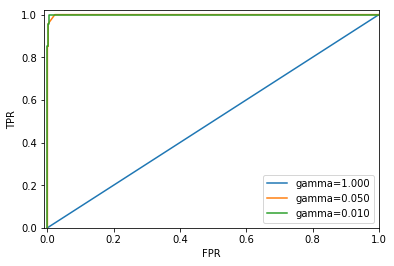

In [57]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(
          gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

The accuracy of all three settings of gamma is the same, 90%. This might be the same as chance performance, or it might not. Looking at the AUC and the corresponding curve, however, we see a clear distinction between the three models. 

With *gamma=1.0*, the AUC is actually at chance level, meaning that the output of the *decision_function* is as good as random. With *gamma=0.05*, performance drastically improves to an AUC of 0.9. Finally, with *gamma=0.01*, we get a perfect AUC of 1.0. That means that all positive points are ranked higher than all negative points according to the decision function. 

In other words, with the right threshold, this model can classify the data perfectly!  Knowing this, we can adjust the threshold on this model and obtain great predictions. If we had only used accuracy, we would never have discovered this.

For this reason, we highly recommend using AUC when evaluating models on imbalanced data. Keep in mind that AUC does not make use of the default threshold, though, so adjusting the decision threshold might be necessary to obtain useful classification results from a model with a high AUC.

### Metrics for Multiclass Classification

Now that we have discussed evaluation of binary classification tasks in depth, let’s move on to metrics to evaluate multiclass classification. Basically, all metrics for multiclass classification are derived from binary classification metrics, but averaged over all classes. 

Accuracy for multiclass classification is again defined as the fraction of correctly classified examples. And again, when classes are imbalanced, accuracy is not a great evaluation measure. Imagine a three-class classification problem with 85% of points belonging to class A, 10% belonging to class B, and 5% belonging to class C. What does being 85% accurate mean on this dataset? 

In general, multiclass classification results are harder to understand than binary classification results. Apart from accuracy, common tools are the confusion matrix and the classification report we saw in the binary case in the previous section. Let’s apply these two detailed evaluation methods on the task of classifying the 10 different handwritten digits in the digits dataset:

In [58]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)

print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


The model has an accuracy of 95.3%, which already tells us that we are doing pretty well. The confusion matrix provides us with some more detail. As for the binary case, each row corresponds to a true label, and each column corresponds to a predicted label. You can find a visually more appealing plot:

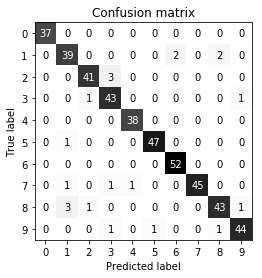

In [59]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")

plt.title("Confusion matrix")
plt.gca().invert_yaxis()

For the first class, the digit 0, there are 37 samples in the class, and all of these samples were classified as class 0 (there are no false negatives for class 0). We can see that because all other entries in the first row of the confusion matrix are 0. We can also see that no other digits were mistakenly classified as 0, because all other entries in the first column of the confusion matrix are 0 (there are no false positives for class 0). Some digits were confused with others, though—for example, the digit 2 (third row), three of which were classified as the digit 3 (fourth column). There was also one digit 3 that was classified as 2 (third column, fourth row) and one digit 8 that was classified as 2 (third column, ninth row).

With the *classification_report* function, we can compute the precision, recall, and f-score for each class:

In [60]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Unsurprisingly, precision and recall are a perfect 1 for class 0, as there are no confusions with this class. For class 7, on the other hand, precision is 1 because no other class was mistakenly classified as 7, while for class 6, there are no false negatives, so the recall is 1. We can also see that the model has particular difficulties with classes 8 and 3.

The most commonly used metric for imbalanced datasets in the multiclass setting is the multiclass version of the f-score. The idea behind the multiclass f-score is to compute one binary f-score per class, with that class being the positive class and the other classes making up the negative classes. Then, these per-class f-scores are averaged using one of the following strategies:

- "macro" averaging computes the unweighted per-class f-scores. This gives equal weight to all classes, no matter what their size is.

- "weighted" averaging computes the mean of the per-class f-scores, weighted by their support. This is what is reported in the classification report.

- "micro" averaging computes the total number of false positives, false negatives, and true positives over all classes, and then computes precision, recall, and f-score using these counts.

If you care about each *sample* equally much, it is recommended to use the "micro" average f1-score; if you care about each *class* equally much, it is recommended to use the "macro" average f1-score:

In [61]:
print("Micro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954
